In [4]:
from mesa import Model, Agent
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
import numpy as np
import matplotlib.pyplot as plt


class SmallWorldAgentBasic(Agent):

    def __init__(self, unique_id, neighbors,  model):
        '''
         Create a new small world agent.

         Args:
            unique_id: Unique identifier for the agent
            neighbors: list of directly reachable agents
        '''

        super().__init__(unique_id, model)
        self.neighbors = neighbors

        self.infected = False
        self.newly_infected = False
        self.dead = False
        self.candidate_infections = []

    def step(self):
        '''
        Run one step of the agent.
        '''
        self.candidate_infections = []
        if self.dead:
            return

        if self.newly_infected:
            self.infected = True

        if self.infected:
            for neighbor in self.neighbors:
                if self.model.random.random() < self.model.infect_probability:
                    self.candidate_infections.append(neighbor)

    def advance(self):
        '''
        advance step of model
        '''

        if self.dead:
            return

        if self.infected:
            for candidate in self.candidate_infections:
                candidate.newly_infected = True
                print("Agent "+str(candidate.unique_id)+" got infected.\n")
            self.dead = True
            print("Agent "+str(self.unique_id)+" died.\n")


In [57]:
def get_halftime(model):
    '''
    Find step when half of the population was infected
    '''
    infected_count = 0
    for i in range(model.num_agents):
        if model.schedule.agents[i].infected:
            infected_count = infected_count+1
    if infected_count >= model.num_agents / 2:
        return True
    else:
        return False

In [58]:
class SmallWorldModel(Model):

    def __init__(self, N, k, p, r):
        '''
        Create a new small world model.

         Args:
            N: how many agents the model contains
            k: how many neighbors an agent has CURRENTLY ONLY EVEN K SUPPORTED
            p: probability of rearranging edge in initialization
            r: probability of infecting another agent
        '''

        super().__init__()

        # 1 Initialization
        self.num_agents = N
        self.num_neighbors = k
        self.swap_probability = p
        self.infect_probability = r

        self.schedule = SimultaneousActivation(self)
        
        self.datacollector = DataCollector(
            model_reporters={"Halftime": get_halftime}, agent_reporters={"Infected": "infected"}
        )
        
        # Create agents
        for i in range(self.num_agents):
            agent = SmallWorldAgentBasic(i, [0]*k, self)
            self.schedule.add(agent)

        agents = self.schedule.agents
        

        # make the k nearest neighbors the official neighbors
        for j in range(int(self.num_neighbors / 2)):
            for i in range(self.num_agents):
                right = (i + j + 1) % self.num_agents
                left = (i - j - 1) % self.num_agents
                agents[i].neighbors[j*2] = agents[right]
                agents[i].neighbors[j*2+1] = agents[left]

        # randomly replace neighbors with new neighbors
        for j in range(self.num_neighbors):
            for i in range(self.num_agents):
                if self.random.random() < self.swap_probability:
                    candidate_agent = self.random.choice(self.schedule.agents)
                    already_connected = True
                    while already_connected:
                        in_neighbors = False
                        for neighbor in agents[i].neighbors:
                            if neighbor == candidate_agent:
                                in_neighbors = True
                        if in_neighbors:
                            candidate_agent = self.random.choice(self.schedule.agents)
                            already_connected = True
                        else:
                            already_connected = False
                    agents[i].neighbors[j] = candidate_agent
                    print("Agent "+str(i)+"'s new Neighbor on position "+str(j)+" is now Agent "+str(candidate_agent.unique_id)+".\n")

        # infect 1 agent
        patient_zero = self.random.choice(self.schedule.agents)
        patient_zero.infected = True
        print("Agent " + str(patient_zero.unique_id) + " got infected.\n")



    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''

        # 3 Step model function
        self.datacollector.collect(self)
        self.schedule.step()

In [59]:
model = SmallWorldModel(100, 4, 0.2, 0.5)
while model.schedule.steps < 100:
    model.step()

Agent 1's new Neighbor on position 0 is now Agent 82.

Agent 6's new Neighbor on position 0 is now Agent 85.

Agent 12's new Neighbor on position 0 is now Agent 21.

Agent 21's new Neighbor on position 0 is now Agent 76.

Agent 25's new Neighbor on position 0 is now Agent 9.

Agent 26's new Neighbor on position 0 is now Agent 22.

Agent 33's new Neighbor on position 0 is now Agent 75.

Agent 36's new Neighbor on position 0 is now Agent 25.

Agent 38's new Neighbor on position 0 is now Agent 81.

Agent 40's new Neighbor on position 0 is now Agent 79.

Agent 49's new Neighbor on position 0 is now Agent 32.

Agent 54's new Neighbor on position 0 is now Agent 40.

Agent 56's new Neighbor on position 0 is now Agent 47.

Agent 69's new Neighbor on position 0 is now Agent 80.

Agent 83's new Neighbor on position 0 is now Agent 43.

Agent 86's new Neighbor on position 0 is now Agent 44.

Agent 96's new Neighbor on position 0 is now Agent 32.

Agent 15's new Neighbor on position 1 is now Agent 

In [68]:
params = {"N": 100, "k": 4, "p": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], "r": 0.5}

In [69]:
from mesa.batchrunner import batch_run

results = batch_run(
    SmallWorldModel,
    parameters=params,
    iterations= 5,
    max_steps= 100,
    number_processes=1,
    data_collection_period= -1,
    display_progress=True,
)

5it [00:00, 41.38it/s]

Agent 38 got infected.

Agent 37 got infected.

Agent 40 got infected.

Agent 36 got infected.

Agent 38 died.

Agent 34 got infected.

Agent 36 died.

Agent 36 got infected.

Agent 39 got infected.

Agent 35 got infected.

Agent 37 died.

Agent 42 got infected.

Agent 38 got infected.

Agent 40 died.

Agent 35 got infected.

Agent 32 got infected.

Agent 34 died.

Agent 36 got infected.

Agent 34 got infected.

Agent 33 got infected.

Agent 35 died.

Agent 38 got infected.

Agent 41 got infected.

Agent 39 died.

Agent 43 got infected.

Agent 41 got infected.

Agent 44 got infected.

Agent 40 got infected.

Agent 42 died.

Agent 33 got infected.

Agent 32 died.

Agent 35 got infected.

Agent 33 died.

Agent 41 died.

Agent 44 got infected.

Agent 45 got infected.

Agent 41 got infected.

Agent 43 died.

Agent 42 got infected.

Agent 44 died.

Agent 46 got infected.

Agent 47 got infected.

Agent 43 got infected.

Agent 45 died.

Agent 47 got infected.

Agent 48 got infected.

Agent 44

15it [00:00, 41.16it/s]

Agent 92 got infected.

Agent 91 got infected.

Agent 92 died.

Agent 92 got infected.

Agent 90 got infected.

Agent 91 died.

Agent 90 died.

Agent 93 got infected.

Agent 94 got infected.

Agent 95 got infected.

Agent 93 died.

Agent 95 got infected.

Agent 96 got infected.

Agent 92 got infected.

Agent 94 died.

Agent 94 got infected.

Agent 97 got infected.

Agent 95 died.

Agent 93 got infected.

Agent 91 got infected.

Agent 90 got infected.

Agent 92 died.

Agent 97 got infected.

Agent 96 died.

Agent 96 got infected.

Agent 99 got infected.

Agent 97 died.

Agent 91 got infected.

Agent 89 got infected.

Agent 90 died.

Agent 90 got infected.

Agent 93 got infected.

Agent 89 got infected.

Agent 91 died.

Agent 98 got infected.

Agent 1 got infected.

Agent 99 died.

Agent 1 died.

Agent 88 got infected.

Agent 91 got infected.

Agent 89 died.

Agent 99 got infected.

Agent 97 got infected.

Agent 98 died.

Agent 90 got infected.

Agent 88 died.

Agent 12's new Neighbor on

30it [00:00, 41.18it/s]

Agent 67 got infected.

Agent 68 got infected.

Agent 67 died.

Agent 67 got infected.

Agent 70 got infected.

Agent 66 got infected.

Agent 68 died.

Agent 67 got infected.

Agent 68 got infected.

Agent 66 died.

Agent 69 got infected.

Agent 68 got infected.

Agent 70 died.

Agent 71 got infected.

Agent 69 died.

Agent 70 got infected.

Agent 71 died.

Agent 55's new Neighbor on position 3 is now Agent 60.

Agent 86 got infected.

Agent 85 got infected.

Agent 86 died.

Agent 86 got infected.

Agent 85 died.

Agent 10's new Neighbor on position 0 is now Agent 62.

Agent 47's new Neighbor on position 2 is now Agent 70.

Agent 71's new Neighbor on position 2 is now Agent 81.

Agent 8's new Neighbor on position 3 is now Agent 3.

Agent 11 got infected.

Agent 12 got infected.

Agent 11 died.

Agent 13 got infected.

Agent 14 got infected.

Agent 10 got infected.

Agent 12 died.

Agent 62 got infected.

Agent 9 got infected.

Agent 12 got infected.

Agent 10 died.

Agent 14 got infect

40it [00:01, 36.98it/s]

Agent 8's new Neighbor on position 0 is now Agent 55.

Agent 16's new Neighbor on position 0 is now Agent 38.

Agent 32's new Neighbor on position 0 is now Agent 98.

Agent 63's new Neighbor on position 0 is now Agent 75.

Agent 78's new Neighbor on position 0 is now Agent 89.

Agent 82's new Neighbor on position 0 is now Agent 94.

Agent 99's new Neighbor on position 0 is now Agent 28.

Agent 3's new Neighbor on position 1 is now Agent 32.

Agent 11's new Neighbor on position 1 is now Agent 86.

Agent 56's new Neighbor on position 1 is now Agent 36.

Agent 57's new Neighbor on position 1 is now Agent 52.

Agent 58's new Neighbor on position 1 is now Agent 85.

Agent 60's new Neighbor on position 1 is now Agent 55.

Agent 82's new Neighbor on position 1 is now Agent 53.

Agent 83's new Neighbor on position 1 is now Agent 41.

Agent 86's new Neighbor on position 1 is now Agent 16.

Agent 1's new Neighbor on position 2 is now Agent 19.

Agent 19's new Neighbor on position 2 is now Agent 

55it [00:01, 39.61it/s]

Agent 0's new Neighbor on position 0 is now Agent 0.

Agent 1's new Neighbor on position 0 is now Agent 44.

Agent 2's new Neighbor on position 0 is now Agent 98.

Agent 3's new Neighbor on position 0 is now Agent 42.

Agent 4's new Neighbor on position 0 is now Agent 92.

Agent 5's new Neighbor on position 0 is now Agent 29.

Agent 6's new Neighbor on position 0 is now Agent 17.

Agent 7's new Neighbor on position 0 is now Agent 48.

Agent 8's new Neighbor on position 0 is now Agent 68.

Agent 9's new Neighbor on position 0 is now Agent 28.

Agent 10's new Neighbor on position 0 is now Agent 21.

Agent 11's new Neighbor on position 0 is now Agent 48.

Agent 12's new Neighbor on position 0 is now Agent 98.

Agent 13's new Neighbor on position 0 is now Agent 2.

Agent 14's new Neighbor on position 0 is now Agent 5.

Agent 15's new Neighbor on position 0 is now Agent 55.

Agent 16's new Neighbor on position 0 is now Agent 39.

Agent 17's new Neighbor on position 0 is now Agent 54.

Agent

65it [00:01, 40.18it/s]

Agent 31's new Neighbor on position 3 is now Agent 28.

Agent 74 got infected.

Agent 75 got infected.

Agent 72 got infected.

Agent 74 died.

Agent 73 got infected.

Agent 74 got infected.

Agent 70 got infected.

Agent 72 died.

Agent 74 got infected.

Agent 75 died.

Agent 69 got infected.

Agent 68 got infected.

Agent 70 died.

Agent 73 died.

Agent 68 died.

Agent 68 got infected.

Agent 69 died.

Agent 45 got infected.

Agent 47 got infected.

Agent 43 got infected.

Agent 45 died.

Agent 44 got infected.

Agent 42 got infected.

Agent 45 got infected.

Agent 41 got infected.

Agent 43 died.

Agent 48 got infected.

Agent 46 got infected.

Agent 45 got infected.

Agent 47 died.

Agent 40 got infected.

Agent 43 got infected.

Agent 39 got infected.

Agent 41 died.

Agent 43 got infected.

Agent 40 got infected.

Agent 42 died.

Agent 44 died.

Agent 47 got infected.

Agent 48 got infected.

Agent 46 died.

Agent 47 got infected.

Agent 50 got infected.

Agent 48 died.

Agent 41

75it [00:01, 40.39it/s]

Agent 9's new Neighbor on position 0 is now Agent 28.

Agent 45's new Neighbor on position 0 is now Agent 63.

Agent 49's new Neighbor on position 0 is now Agent 81.

Agent 56's new Neighbor on position 0 is now Agent 28.

Agent 63's new Neighbor on position 0 is now Agent 19.

Agent 64's new Neighbor on position 0 is now Agent 71.

Agent 68's new Neighbor on position 0 is now Agent 72.

Agent 72's new Neighbor on position 0 is now Agent 32.

Agent 83's new Neighbor on position 0 is now Agent 98.

Agent 87's new Neighbor on position 0 is now Agent 94.

Agent 12's new Neighbor on position 1 is now Agent 84.

Agent 19's new Neighbor on position 1 is now Agent 62.

Agent 29's new Neighbor on position 1 is now Agent 42.

Agent 30's new Neighbor on position 1 is now Agent 81.

Agent 32's new Neighbor on position 1 is now Agent 80.

Agent 38's new Neighbor on position 1 is now Agent 98.

Agent 43's new Neighbor on position 1 is now Agent 67.

Agent 72's new Neighbor on position 1 is now Agen

85it [00:02, 40.79it/s]

Agent 1's new Neighbor on position 0 is now Agent 95.

Agent 2's new Neighbor on position 0 is now Agent 94.

Agent 3's new Neighbor on position 0 is now Agent 8.

Agent 4's new Neighbor on position 0 is now Agent 59.

Agent 5's new Neighbor on position 0 is now Agent 27.

Agent 9's new Neighbor on position 0 is now Agent 39.

Agent 12's new Neighbor on position 0 is now Agent 80.

Agent 13's new Neighbor on position 0 is now Agent 50.

Agent 14's new Neighbor on position 0 is now Agent 38.

Agent 16's new Neighbor on position 0 is now Agent 63.

Agent 19's new Neighbor on position 0 is now Agent 12.

Agent 20's new Neighbor on position 0 is now Agent 77.

Agent 21's new Neighbor on position 0 is now Agent 38.

Agent 22's new Neighbor on position 0 is now Agent 90.

Agent 24's new Neighbor on position 0 is now Agent 11.

Agent 26's new Neighbor on position 0 is now Agent 18.

Agent 30's new Neighbor on position 0 is now Agent 17.

Agent 32's new Neighbor on position 0 is now Agent 47.


100it [00:02, 41.11it/s]

Agent 54 got infected.

Agent 53 got infected.

Agent 56 got infected.

Agent 52 got infected.

Agent 54 died.

Agent 52 died.

Agent 52 got infected.

Agent 55 got infected.

Agent 53 died.

Agent 57 got infected.

Agent 55 got infected.

Agent 58 got infected.

Agent 54 got infected.

Agent 56 died.

Agent 54 got infected.

Agent 57 got infected.

Agent 53 got infected.

Agent 55 died.

Agent 58 got infected.

Agent 56 got infected.

Agent 59 got infected.

Agent 55 got infected.

Agent 57 died.

Agent 60 got infected.

Agent 58 died.

Agent 58 got infected.

Agent 61 got infected.

Agent 59 died.

Agent 59 got infected.

Agent 62 got infected.

Agent 58 got infected.

Agent 60 died.

Agent 62 got infected.

Agent 59 got infected.

Agent 61 died.

Agent 61 got infected.

Agent 62 died.

Agent 48 got infected.

Agent 49 got infected.

Agent 47 got infected.

Agent 50 got infected.

Agent 46 got infected.

Agent 48 died.

Agent 48 got infected.

Agent 44 got infected.

Agent 46 died.



110it [00:02, 41.33it/s]

Agent 59 got infected.

Agent 60 got infected.

Agent 58 got infected.

Agent 61 got infected.

Agent 57 got infected.

Agent 59 died.

Agent 58 got infected.

Agent 56 got infected.

Agent 57 died.

Agent 56 got infected.

Agent 58 died.

Agent 61 got infected.

Agent 59 got infected.

Agent 60 died.

Agent 60 got infected.

Agent 59 got infected.

Agent 61 died.

Agent 57 got infected.

Agent 58 got infected.

Agent 56 died.

Agent 14 got infected.

Agent 13 got infected.

Agent 14 died.

Agent 14 got infected.

Agent 12 got infected.

Agent 15 got infected.

Agent 11 got infected.

Agent 13 died.

Agent 12 got infected.

Agent 9 got infected.

Agent 11 died.

Agent 11 got infected.

Agent 12 died.

Agent 16 got infected.

Agent 17 got infected.

Agent 13 got infected.

Agent 15 died.

Agent 10 got infected.

Agent 7 got infected.

Agent 9 died.

Agent 18 got infected.

Agent 16 died.

Agent 19 got infected.

Agent 17 died.

Agent 6 got infected.

Agent 5 got infected.

Agent 7 died.

120it [00:03, 37.11it/s]

Agent 8's new Neighbor on position 0 is now Agent 21.

Agent 13's new Neighbor on position 0 is now Agent 34.

Agent 24's new Neighbor on position 0 is now Agent 90.

Agent 34's new Neighbor on position 0 is now Agent 46.

Agent 66's new Neighbor on position 0 is now Agent 99.

Agent 77's new Neighbor on position 0 is now Agent 16.

Agent 80's new Neighbor on position 0 is now Agent 89.

Agent 11's new Neighbor on position 1 is now Agent 27.

Agent 12's new Neighbor on position 1 is now Agent 54.

Agent 19's new Neighbor on position 1 is now Agent 92.

Agent 39's new Neighbor on position 1 is now Agent 94.

Agent 73's new Neighbor on position 1 is now Agent 87.

Agent 79's new Neighbor on position 1 is now Agent 3.

Agent 90's new Neighbor on position 1 is now Agent 35.

Agent 92's new Neighbor on position 1 is now Agent 46.

Agent 3's new Neighbor on position 2 is now Agent 76.

Agent 24's new Neighbor on position 2 is now Agent 66.

Agent 83's new Neighbor on position 2 is now Agent 

130it [00:03, 39.03it/s]

Agent 0's new Neighbor on position 0 is now Agent 46.

Agent 1's new Neighbor on position 0 is now Agent 64.

Agent 2's new Neighbor on position 0 is now Agent 11.

Agent 3's new Neighbor on position 0 is now Agent 61.

Agent 4's new Neighbor on position 0 is now Agent 16.

Agent 5's new Neighbor on position 0 is now Agent 30.

Agent 6's new Neighbor on position 0 is now Agent 13.

Agent 7's new Neighbor on position 0 is now Agent 29.

Agent 8's new Neighbor on position 0 is now Agent 93.

Agent 9's new Neighbor on position 0 is now Agent 46.

Agent 10's new Neighbor on position 0 is now Agent 10.

Agent 11's new Neighbor on position 0 is now Agent 11.

Agent 12's new Neighbor on position 0 is now Agent 1.

Agent 13's new Neighbor on position 0 is now Agent 68.

Agent 14's new Neighbor on position 0 is now Agent 34.

Agent 15's new Neighbor on position 0 is now Agent 48.

Agent 16's new Neighbor on position 0 is now Agent 71.

Agent 17's new Neighbor on position 0 is now Agent 64.

Age

140it [00:03, 39.90it/s]

Agent 47 got infected.

Agent 46 got infected.

Agent 49 got infected.

Agent 47 died.

Agent 47 got infected.

Agent 45 got infected.

Agent 48 got infected.

Agent 44 got infected.

Agent 46 died.

Agent 50 got infected.

Agent 48 got infected.

Agent 49 died.

Agent 43 got infected.

Agent 42 got infected.

Agent 44 died.

Agent 46 got infected.

Agent 44 got infected.

Agent 45 died.

Agent 50 got infected.

Agent 48 died.

Agent 51 got infected.

Agent 49 got infected.

Agent 50 died.

Agent 44 got infected.

Agent 40 got infected.

Agent 42 died.

Agent 42 got infected.

Agent 43 died.

Agent 52 got infected.

Agent 50 got infected.

Agent 53 got infected.

Agent 49 got infected.

Agent 51 died.

Agent 39 got infected.

Agent 42 got infected.

Agent 40 died.

Agent 54 got infected.

Agent 52 died.

Agent 55 got infected.

Agent 51 got infected.

Agent 53 died.

Agent 37 got infected.

Agent 39 died.

Agent 56 got infected.

Agent 54 died.

Agent 56 got infected.

Agent 57 got inf

150it [00:03, 40.50it/s]

Agent 52 got infected.

Agent 54 died.

Agent 51 got infected.

Agent 50 got infected.

Agent 52 died.

Agent 49 got infected.

Agent 50 died.

Agent 52 got infected.

Agent 50 got infected.

Agent 53 got infected.

Agent 51 died.

Agent 50 got infected.

Agent 47 got infected.

Agent 49 died.

Agent 52 got infected.

Agent 53 died.

Agent 48 got infected.

Agent 46 got infected.

Agent 45 got infected.

Agent 47 died.

Agent 47 got infected.

Agent 43 got infected.

Agent 45 died.

Agent 46 died.

Agent 46 got infected.

Agent 48 died.

Agent 42 got infected.

Agent 45 got infected.

Agent 43 died.

Agent 41 got infected.

Agent 40 got infected.

Agent 42 died.

Agent 39 got infected.

Agent 38 got infected.

Agent 40 died.

Agent 42 got infected.

Agent 40 got infected.

Agent 39 got infected.

Agent 41 died.

Agent 39 got infected.

Agent 37 got infected.

Agent 36 got infected.

Agent 38 died.

Agent 39 died.

Agent 35 got infected.

Agent 38 got infected.

Agent 36 died.

Agent 35

165it [00:04, 41.04it/s]

Agent 81 got infected.

Agent 80 got infected.

Agent 79 got infected.

Agent 81 died.

Agent 79 died.

Agent 81 got infected.

Agent 80 died.

Agent 48 got infected.

Agent 50 got infected.

Agent 46 got infected.

Agent 48 died.

Agent 48 got infected.

Agent 46 died.

Agent 49 got infected.

Agent 48 got infected.

Agent 50 died.

Agent 47 got infected.

Agent 49 died.

Agent 48 got infected.

Agent 46 got infected.

Agent 45 got infected.

Agent 47 died.

Agent 46 got infected.

Agent 44 got infected.

Agent 45 died.

Agent 45 got infected.

Agent 43 got infected.

Agent 46 got infected.

Agent 44 died.

Agent 42 got infected.

Agent 43 died.

Agent 43 got infected.

Agent 41 got infected.

Agent 44 got infected.

Agent 42 died.

Agent 42 got infected.

Agent 43 got infected.

Agent 39 got infected.

Agent 41 died.

Agent 41 got infected.

Agent 39 died.

Agent 87 got infected.

Agent 87 died.

Agent 22 got infected.

Agent 23 got infected.

Agent 22 died.

Agent 25 got infected.



175it [00:04, 41.04it/s]

Agent 33's new Neighbor on position 0 is now Agent 59.

Agent 20's new Neighbor on position 3 is now Agent 59.

Agent 34's new Neighbor on position 3 is now Agent 11.

Agent 94's new Neighbor on position 3 is now Agent 15.

Agent 19 got infected.

Agent 18 got infected.

Agent 19 died.

Agent 19 got infected.

Agent 17 got infected.

Agent 16 got infected.

Agent 18 died.

Agent 17 got infected.

Agent 14 got infected.

Agent 16 died.

Agent 15 got infected.

Agent 17 died.

Agent 12 got infected.

Agent 14 died.

Agent 16 got infected.

Agent 13 got infected.

Agent 15 died.

Agent 12 died.

Agent 12 got infected.

Agent 15 got infected.

Agent 13 died.

Agent 1's new Neighbor on position 0 is now Agent 81.

Agent 97's new Neighbor on position 0 is now Agent 17.

Agent 23's new Neighbor on position 1 is now Agent 74.

Agent 22's new Neighbor on position 2 is now Agent 75.

Agent 69's new Neighbor on position 3 is now Agent 39.

Agent 88's new Neighbor on position 3 is now Agent 72.

A

180it [00:04, 40.82it/s]

Agent 5's new Neighbor on position 0 is now Agent 95.

Agent 30's new Neighbor on position 0 is now Agent 82.

Agent 42's new Neighbor on position 0 is now Agent 34.

Agent 44's new Neighbor on position 0 is now Agent 0.

Agent 56's new Neighbor on position 0 is now Agent 35.

Agent 6's new Neighbor on position 1 is now Agent 55.

Agent 8's new Neighbor on position 1 is now Agent 58.

Agent 21's new Neighbor on position 1 is now Agent 11.

Agent 38's new Neighbor on position 1 is now Agent 0.

Agent 51's new Neighbor on position 1 is now Agent 7.

Agent 96's new Neighbor on position 1 is now Agent 84.

Agent 20's new Neighbor on position 2 is now Agent 33.

Agent 76's new Neighbor on position 2 is now Agent 53.

Agent 8's new Neighbor on position 3 is now Agent 26.

Agent 18's new Neighbor on position 3 is now Agent 36.

Agent 26's new Neighbor on position 3 is now Agent 75.

Agent 38's new Neighbor on position 3 is now Agent 4.

Agent 41's new Neighbor on position 3 is now Agent 29.



190it [00:04, 40.94it/s]

Agent 32's new Neighbor on position 0 is now Agent 87.

Agent 82's new Neighbor on position 0 is now Agent 91.

Agent 14's new Neighbor on position 2 is now Agent 77.

Agent 42's new Neighbor on position 2 is now Agent 97.

Agent 5's new Neighbor on position 3 is now Agent 19.

Agent 49 got infected.

Agent 50 got infected.

Agent 48 got infected.

Agent 51 got infected.

Agent 47 got infected.

Agent 49 died.

Agent 48 got infected.

Agent 45 got infected.

Agent 47 died.

Agent 49 got infected.

Agent 48 died.

Agent 49 got infected.

Agent 50 died.

Agent 50 got infected.

Agent 49 got infected.

Agent 51 died.

Agent 46 got infected.

Agent 44 got infected.

Agent 43 got infected.

Agent 45 died.

Agent 44 got infected.

Agent 45 got infected.

Agent 43 died.

Agent 45 got infected.

Agent 46 got infected.

Agent 42 got infected.

Agent 44 died.

Agent 44 got infected.

Agent 46 died.

Agent 41 got infected.

Agent 97 got infected.

Agent 40 got infected.

Agent 42 died.

Agent 41 

200it [00:05, 35.40it/s]

Agent 53's new Neighbor on position 0 is now Agent 68.

Agent 74's new Neighbor on position 0 is now Agent 47.

Agent 72's new Neighbor on position 2 is now Agent 67.

Agent 92's new Neighbor on position 2 is now Agent 58.

Agent 82 got infected.

Agent 83 got infected.

Agent 84 got infected.

Agent 80 got infected.

Agent 82 died.

Agent 81 got infected.

Agent 80 died.

Agent 84 got infected.

Agent 82 got infected.

Agent 85 got infected.

Agent 83 died.

Agent 85 got infected.

Agent 84 died.

Agent 82 got infected.

Agent 80 got infected.

Agent 81 died.

Agent 86 got infected.

Agent 83 got infected.

Agent 85 died.

Agent 85 got infected.

Agent 88 got infected.

Agent 84 got infected.

Agent 86 died.

Agent 89 got infected.

Agent 87 got infected.

Agent 86 got infected.

Agent 88 died.

Agent 89 got infected.

Agent 87 died.

Agent 90 got infected.

Agent 91 got infected.

Agent 89 died.

Agent 91 got infected.

Agent 89 got infected.

Agent 92 got infected.

Agent 88 got inf

205it [00:05, 36.91it/s]

Agent 33's new Neighbor on position 0 is now Agent 38.

Agent 96 got infected.

Agent 95 got infected.

Agent 96 died.

Agent 96 got infected.

Agent 94 got infected.

Agent 97 got infected.

Agent 93 got infected.

Agent 95 died.

Agent 92 got infected.

Agent 91 got infected.

Agent 93 died.

Agent 93 got infected.

Agent 92 got infected.

Agent 94 died.

Agent 96 got infected.

Agent 99 got infected.

Agent 97 died.

Agent 93 got infected.

Agent 89 got infected.

Agent 91 died.

Agent 93 got infected.

Agent 91 got infected.

Agent 94 got infected.

Agent 92 died.

Agent 1 got infected.

Agent 99 died.

Agent 3 got infected.

Agent 99 got infected.

Agent 1 died.

Agent 91 got infected.

Agent 87 got infected.

Agent 89 died.

Agent 2 got infected.

Agent 5 got infected.

Agent 1 got infected.

Agent 3 died.

Agent 88 got infected.

Agent 86 got infected.

Agent 89 got infected.

Agent 87 died.

Agent 3 got infected.

Agent 2 died.

Agent 6 got infected.

Agent 3 got infected.

Age

220it [00:05, 39.24it/s]

Agent 77's new Neighbor on position 0 is now Agent 98.

Agent 47's new Neighbor on position 2 is now Agent 40.

Agent 87's new Neighbor on position 2 is now Agent 82.

Agent 61 got infected.

Agent 60 got infected.

Agent 61 died.

Agent 61 got infected.

Agent 59 got infected.

Agent 62 got infected.

Agent 60 died.

Agent 61 got infected.

Agent 59 died.

Agent 61 got infected.

Agent 62 died.

Agent 14's new Neighbor on position 0 is now Agent 80.

Agent 29's new Neighbor on position 1 is now Agent 34.

Agent 37's new Neighbor on position 3 is now Agent 24.

Agent 79 got infected.

Agent 81 got infected.

Agent 79 died.

Agent 82 got infected.

Agent 80 got infected.

Agent 83 got infected.

Agent 79 got infected.

Agent 81 died.

Agent 79 got infected.

Agent 82 got infected.

Agent 80 died.

Agent 83 got infected.

Agent 81 got infected.

Agent 82 died.

Agent 82 got infected.

Agent 83 died.

Agent 2's new Neighbor on position 0 is now Agent 33.

Agent 7's new Neighbor on positio

225it [00:05, 39.63it/s]


In [70]:
import pandas as pd

results_df = pd.DataFrame(results)
display(results_df)

,RunId,iteration,Step,N,k,p,r,Halftime,AgentID,Infected
0,0,-1,100,100,4,0.0001,0.5,False,0,False
1,0,-1,100,100,4,0.0001,0.5,False,1,False
2,0,-1,100,100,4,0.0001,0.5,False,2,False
3,0,-1,100,100,4,0.0001,0.5,False,3,False
4,0,-1,100,100,4,0.0001,0.5,False,4,False
...,...,...,...,...,...,...,...,...,...,...
22495,224,3,100,100,4,1.0000,0.5,True,95,True
22496,224,3,100,100,4,1.0000,0.5,True,96,True
22497,224,3,100,100,4,1.0000,0.5,True,97,False
22498,224,3,100,100,4,1.0000,0.5,True,98,False


         RunId  iteration    Step       N      k       r  Halftime  AgentID  \
p                                                                             
0.0001  270000       2500  250000  250000  10000  1250.0       100   123750   
0.0005  272500       2500  250000  250000  10000  1250.0         0   123750   
0.0010  275000       2500  250000  250000  10000  1250.0       100   123750   
0.0050  277500       2500  250000  250000  10000  1250.0         0   123750   
0.0100  280000       2500  250000  250000  10000  1250.0       200   123750   
0.0500  282500       2500  250000  250000  10000  1250.0       500   123750   
0.1000  285000       2500  250000  250000  10000  1250.0      1300   123750   
0.5000  287500       2500  250000  250000  10000  1250.0      2000   123750   
1.0000  290000       2500  250000  250000  10000  1250.0      2300   123750   

        Infected  
p                 
0.0001       384  
0.0005       318  
0.0010       392  
0.0050       342  
0.0100       427

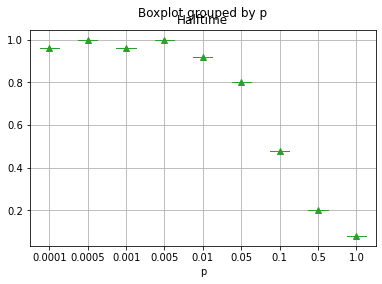

In [78]:
# Halbwertszeit infected
rearranging_df = results_df.groupby(by=["p"]).sum()
print(rearranging_df)
rearranging_df['Halftime'] = (rearranging_df["iteration"][1]-rearranging_df['Halftime'])/rearranging_df["iteration"][1]
df_cutted = pd.DataFrame(rearranging_df, columns = ["Halftime"])
print(df_cutted)
boxplot = df_cutted.boxplot(column = ["Halftime"], by='p', showmeans = True)